In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix 
from scipy.spatial.distance import cdist 
from scipy import stats
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu 
from skimage import io, exposure 
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle 
import pickle
import os
from train import read_binarize, normalize

In [2]:
img = io.imread('H1-16images/test1.bmp')
print(img.shape)

(750, 525)


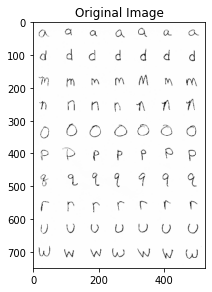

In [3]:
io.imshow(img)
plt.title('Original Image')
io.show()

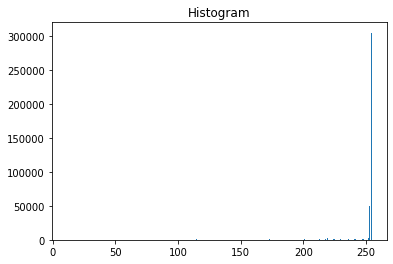

In [4]:
hist = exposure.histogram(img)
plt.bar(hist[1], hist[0])
plt.title('Histogram')
plt.show()

In [5]:
th = 200
img_binary = (img < th).astype(np.double)

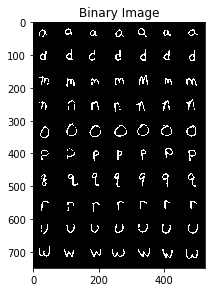

In [6]:
io.imshow(img_binary)
plt.title('Binary Image')
io.show()

In [7]:
img_label = label(img_binary, background=0)

/Users/advithchegu/.local/share/virtualenvs/Computer_Vision-j7KnroHV/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


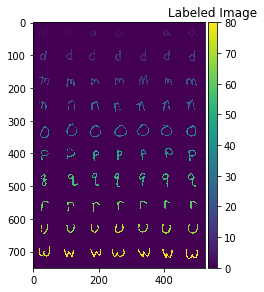

In [8]:
io.imshow(img_label)
plt.title('Labeled Image')
io.show()

In [9]:
print(np.amax(img_label))

80


In [10]:
#store the statistical information
features = []

In [11]:
# build training set
def build_set(minr, minc, maxr, maxc):
    roi = img_binary[minr:maxr, minc:maxc]
    m = moments(roi)
    cr = m[0, 1] / m[0, 0]
    cc = m[1, 0] / m[0, 0]
    center = (cr, cc)
    mu = moments_central(roi, center)
    nu = moments_normalized(mu)
    hu = moments_hu(nu)
    features.append(hu)

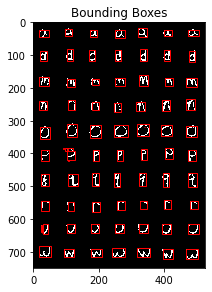

In [12]:
regions = regionprops(img_label)
io.imshow(img_binary)
ax = plt.gca()
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    height = maxr - minr
    width = maxc - minc
    if width > 15 and height > 15:
        build_set(minr, minc, maxr, maxc)
    ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill = False, edgecolor = 'red', linewidth = 1))
ax.set_title('Bounding Boxes')
io.show()

In [13]:
print("Height: ", len(features), "Width: ", len(features[0]))

Height:  70 Width:  7


In [24]:
# go through all the images and get all the features
features = {}
directory_name = './H1-16images/'
for file_name in sorted(os.listdir(directory_name)):
    f = file_name.replace('.bmp', '')
    print(f)
    if f not in ('test1', 'test2'):
        features[f] = read_binarize(directory_name + file_name, 200)

a
d
f
h
k
m
n
o
p
q
r
s
test1
test2
u
w
x
z


In [51]:
combined, flat, normalized, mean, std_dev = normalize(features)
print('mean: ', mean)
print('standard dev: ', std_dev)

# new matrix to hold the mean of each key/features
letter_locs = {}
count = 0

# create the label vector
for k in normalized.keys():
    for i in range(count, count+len(normalized[k])):
        letter_locs[i] = k
    count += len(normalized[k])

conc = np.concatenate([normalized[k] for k in normalized])

mean:  69358362.17967533
standard dev:  6468058923.950656


/Users/advithchegu/.local/share/virtualenvs/Computer_Vision-j7KnroHV/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
/Users/advithchegu/.local/share/virtualenvs/Computer_Vision-j7KnroHV/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


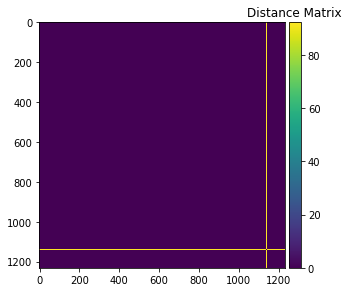

In [52]:
D = cdist(conc, conc)
io.imshow(D)
plt.title('Distance Matrix')
io.show()

In [58]:
D_index = np.argsort(D, axis=1)

total = 0
corr = 0

for i, d in enumerate(D_index):
    if letter_locs[i] == letter_locs[d[1]]:
        corr += 1
    total += 1

acc = corr/total
print(acc)

# confm = confusion_matrix([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], D_index[:,0])
# io.imshow(confm)
# plt.title('Confusion Matrix')
# io.show()

0.525974025974026


In [74]:
letters_mapping = ['a', 'd', 'f', 'h', 'k', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'w', 'x', 'z']

test_1 = read_binarize('H1-16images/test1.bmp', 200)
test_2 = read_binarize('H1-16images/test1.bmp', 200)
normalized_test_1  = (test_1 - mean)/std_dev
normalized_test_2  = (test_2 - mean)/std_dev

In [75]:
D_1 = cdist(normalized_test_1, conc)
D_2 = cdist(normalized_test_2, conc)
rankings_1 = np.argsort(D_1, axis=1)
rankings_2 = np.argsort(D_2, axis=1)

total = 0
corr = 0

for i, d in enumerate(rankings_1):
    if letters_mapping[int(i/7)] == letter_locs[d[0]]:
        corr += 1
    total += 1
acc = corr/total
print('First test accuracy: ', acc)

for i, d in enumerate(rankings_2):
    if letters_mapping[int(i/8)] == letter_locs[d[0]]:
        corr += 1
    total += 1
acc = corr/total
print('Second test accuracy: ', acc)

First test accuracy:  0.17142857142857143
Second test accuracy:  0.15714285714285714
